# imports

In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
ffmpg_path = os.path.abspath(r'C:\Users\pedro\OneDrive\Área de Trabalho\math_s\ffmpeg-20191101-53c21c2-win64-static\bin\ffmpeg.exe')
# os.environ['path'] += ';' + ffmpg_path
plt.rcParams['animation.ffmpeg_path'] = ffmpg_path

# Tools

In [3]:
def cosine(time_vector, f, amplitude=1, phase=2, norm_above_zero=True):
    cos = np.cos(phase * np.pi * f * time_vector)
    if norm_above_zero:
        minimun = np.min(cos)
        if 0 > minimun:
            cos -= minimun
        cos /= np.max(cos)
    return amplitude * cos

In [4]:
def plot_freq_points(frequency, time, x_offset=0, y_offset=0):
    period = 1 / frequency
    for i in np.arange(period, time + period, period):
        plt.plot(i + x_offset, y_offset, marker='o', color='r')

# Motivation

These days, I was talking with a friend of mine about a undergraduate thesis. The paper was pretty cool, the main goal was to create a software able to identify the notes produced by an acoustic guitar. In the same moment, I caught  my self thinking about spectrograms, wavelets, transforms, integrals and all the things that any fourth semester elctrical engineering studant that would be learning the mysteries of DSP would think. But no. My friend got my ideas and trashed them all, by saying:

    - Isn't that kind of basic? Those media files don't come with the music notes kindoff declared?
    
Sure, is totally acceptable that people in general thinks that. It makes perfect sense to store sounds declaratively, if you think only about the notes. A "structured" way enought like csv, yaml, json should be to store and make the "music" playable... It took me a few seconds to think about this format of sound files:


In [5]:
data = [
    ('A', '00:00:00', '00:00:01'),
    ('D', '00:00:01', '00:00:02'),
    ('A', '00:00:01', '00:00:03'),
    ('E', '00:00:03', '00:00:04'),
    ('A', '00:00:03', '00:00:06'),
]
df = pd.DataFrame(data, columns=['note', 'start', 'finish'])
df

,note,start,finish
0,A,00:00:00,00:00:01
1,D,00:00:01,00:00:02
2,A,00:00:01,00:00:03
3,E,00:00:03,00:00:04
4,A,00:00:03,00:00:06


In [6]:
json_string = json.dumps(
    [
        {'note': 'A', 'duration': 2},
        {'note': 'E', 'duration': 2},
        {'note': 'C', 'duration': 4},
        {'note': 'A', 'duration': 2},
        {'note': 'G', 'duration': 2}
    ], indent=4
)
print(json_string)

[
    {
        "note": "A",
        "duration": 2
    },
    {
        "note": "E",
        "duration": 2
    },
    {
        "note": "C",
        "duration": 4
    },
    {
        "note": "A",
        "duration": 2
    },
    {
        "note": "G",
        "duration": 2
    }
]


If we have the notes already stored, its possible to make them occur together following these sequences or rules. But notice, this is not how sound waves are stored.
To understand the record process we need to understand some things about the hardware. 

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ6Z6rPDM6K87EmkQjb51JauHJe3TZbIFdaKrtBU-yFcdq5rgRW)

The microphone is a hardware that turns the vibrations in the air generated by our mounth or by the guitar strings into voltage variances. It has a mechanism that converts the mechanical vibration into a variance of impedance that provokes the variance of voltage.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSXElAXEIkhqgDksKlXcW6zPVtmYjUMp2VoqQ1a_8qqU9NpH61q)

The waves make the diaphragm oscilate. The diaphragm going back and forward with in the same **frequency** as the sound wave generates a variance of voltage in the same **frequency**. 
    
    So, how can we understand this oscilations? And how they look like?

# Lets put a face to that

![](https://media3.giphy.com/media/YxeWytfutfU5i/source.gif)

    Doesn't it look like this?

![](https://media1.giphy.com/media/F5rQlfTXqCJ8c/giphy.gif)

Thus waves in the physical (analog) world are continuous! In every two instants there are an infinitude of points (samples)... And we can not store an infinitude of voltage samples... Our wave inside our media files will look something like this:

In [7]:
print('  3|.                ..                ..                ..                ..                ..                .')
print('  2|  .            .    .            .    .            .    .            .    .            .    .            .  ')
print('  1|   .          .      .          .      .          .      .          .      .          .      .          .   ')
print('  0|    .        .        .        .        .        .        .        .        .        .        .        .    ')
print(' -1|     .      .          .      .          .      .          .      .          .      .          .      .     ')
print(' -2|      .    .            .    .            .    .            .    .            .    .            .    .      ')
print(' -3|        ..                ..                ..                ..                ..                ..        ')
print(' __|____________________________________________________________________________________________________________')
print('   | 0              20              40              60              80              100              120        ')


  3|.                ..                ..                ..                ..                ..                .
  2|  .            .    .            .    .            .    .            .    .            .    .            .  
  1|   .          .      .          .      .          .      .          .      .          .      .          .   
  0|    .        .        .        .        .        .        .        .        .        .        .        .    
 -1|     .      .          .      .          .      .          .      .          .      .          .      .     
 -2|      .    .            .    .            .    .            .    .            .    .            .    .      
 -3|        ..                ..                ..                ..                ..                ..        
 __|____________________________________________________________________________________________________________
   | 0              20              40              60              80              100         

    But we will not use prints to create our plots!

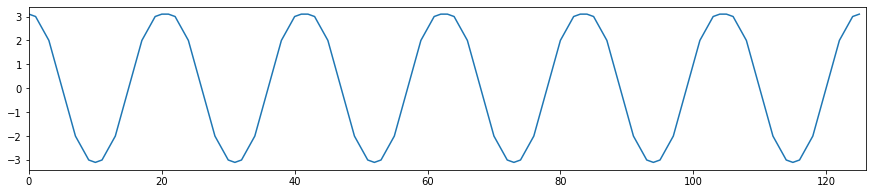

In [8]:
nrepetitions = 6
voltages = nrepetitions * [3.1, 3, 2.5, 2,  1, 0, -1, -2, -2.5, -3, -3.1, -3, -2.5, -2, -1, 0, 1, 2, 2.5, 3, 3.1]
plt.figure(figsize=(15, 3))
plt.plot(voltages)
plt.xlim([0, len(voltages)])
plt.show()

Sound waves recorded by microphones will be arrays that each value correspond to the height of the wave (amplitude or volume) and the index (0, 1, 2, 3) will correspond to the instant that that height occurs. T

In our playground here we will use 100 samples per second as our "Sampling Frequency". So every 1 second interval we will contain 100 "voltage" samples. 100 samples per second can, also, be called 100hz in honor to german physicist Heinrich Hertz.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTkcbL_P8yEkDUIxNL1pgFVSyGjsa9CRFNb__Mm2Nu1M5cTYGBb)

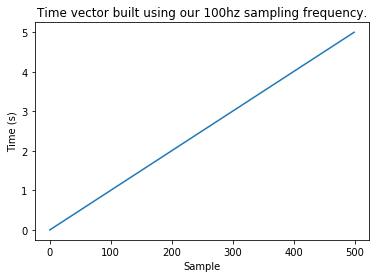

In [9]:
sampling_frequency = 100
time = 5
time_vector = np.linspace(0, time, int(sampling_frequency * time))
plt.plot(time_vector)
plt.ylabel('Time (s)')
plt.xlabel('Sample')
plt.title('Time vector built using our 100hz sampling frequency.')
plt.show()

A time vector that contains all the seconds with $1/100$ seconds between them from 0 to 5 seconds.

You probably could see, in that acoustic guitar gif, that the strings that produce a higher sound vibrate "more" and the strings that produce a lower sound vibrate "less". This effect is due to the component that identify the tune of the note: the frequency itself. The volume of the note is how far the strings go alway from its center of vibration.

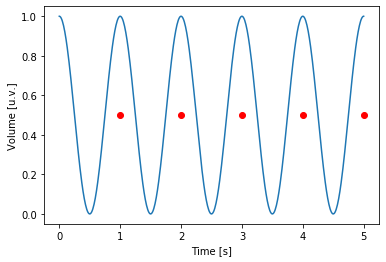

In [10]:
cos_1_vector = (cosine(time_vector, 1))
plt.plot(time_vector, cos_1_vector)
plot_freq_points(1, time, y_offset=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Volume [u.v.]')
plt.show()

So we can emulate the behavior of a note using simple cosine generations. In which we will have the tune of the notes beeing the frequency of the cosine. Lets create a cosine with 1hz using our time vector.

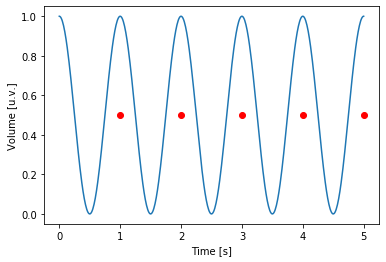

In [11]:
cos_1_vector = (cosine(time_vector, 1))
plt.plot(time_vector, cos_1_vector)
plot_freq_points(1, time, y_offset=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Volume [u.v.]')
plt.show()

If we count the red dots, we will see that the wave repeats itself 5 times in 5 seconds. That is, 5 repetitions in 5 seconds = 1hz. A cosine that have only one repeatition in 5 seconds will have 1/5hz.

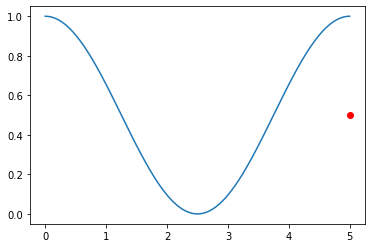

In [12]:
cos_02_vector = cosine(time_vector, 0.2)
plt.plot(time_vector, cos_02_vector)
plot_freq_points(0.2, time, y_offset=0.5)
plt.show()

Based on the basic behavior of the cosine waves we can try to make an algorithm to find their curves by only counting the peeks and vales. It follows this steps

1. find all the peeks and vales.
1. calculate the wave length in seconds.
1. calculate the frequency by dividing the number of peels and vales divided by 2 divided by the wave length.

In [13]:
def find_frequency(signal, freq=sampling_frequency):
    going_up = signal[0] > signal[1]
    going_down = signal[0] < signal[1]

    wave_length_s = len(signal) / freq
    print(f'Wave duration: {wave_length_s}s')
    print()
    peeks, vales = 0, 0
    sample_t_1 = signal[0]
    for i, sample_t in enumerate(signal[1:]):
        if (sample_t > signal[i]) and going_down:
            peeks += 1
            going_down = False
            going_up = True

        elif (signal[i] > sample_t) and going_up:
            vales += 1
            going_up = False
            going_down = True
            
        frequency = ((peeks + vales) / 2) / wave_length_s
    print(f'Found {peeks} peeks in {wave_length_s}s.')
    print(f'Found {vales} vales in {wave_length_s}s.')
    print(f'The calculated frequency is {frequency}hz.')
    print()   

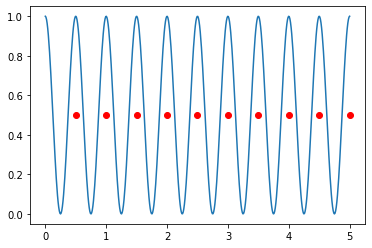

Wave duration: 5.0s

Found 10 peeks in 5.0s.
Found 10 vales in 5.0s.
The calculated frequency is 2.0hz.



In [14]:
cos_2_vector = cosine(time_vector, 2)
plt.plot(time_vector, cos_2_vector)
plot_freq_points(2, time, y_offset=0.5)
plt.show()
find_frequency(cos_2_vector)

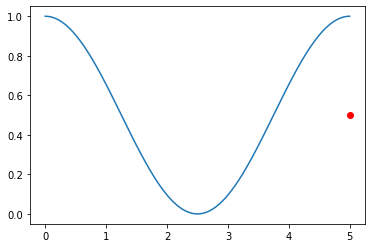

Wave duration: 5.0s

Found 1 peeks in 5.0s.
Found 1 vales in 5.0s.
The calculated frequency is 0.2hz.



In [15]:
cos_02_vector = cosine(time_vector, 0.2)
plt.plot(time_vector, cos_02_vector)
plot_freq_points(0.2, time, y_offset=0.5)
plt.show()
find_frequency(cos_02_vector)

# Problem.

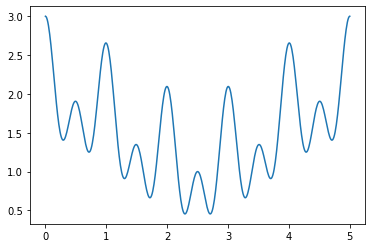

Wave duration: 5.0s

Found 10 peeks in 5.0s.
Found 10 vales in 5.0s.
The calculated frequency is 2.0hz.



In [16]:
combined_cosine_vector = cos_02_vector + cos_2_vector + cos_1_vector
plt.plot(time_vector, combined_cosine_vector)
plt.show()
find_frequency(combined_cosine_vector)

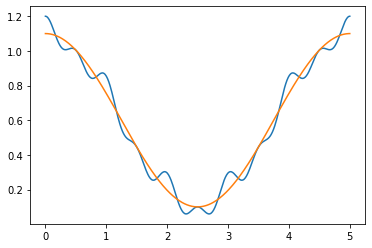

In [17]:
combined_cosine_vector = cos_02_vector + 0.1 * cos_2_vector + 0.1 * cos_1_vector
plt.plot(time_vector, combined_cosine_vector)
plt.plot(time_vector, cos_02_vector + 0.1)
plt.show()

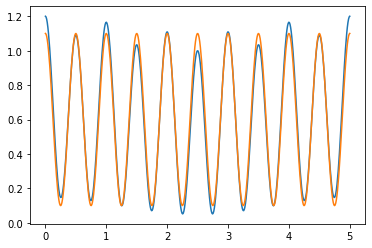

In [18]:
combined_cosine_vector = 0.1 * cos_02_vector + cos_2_vector + 0.1 * cos_1_vector
plt.plot(time_vector, combined_cosine_vector)
plt.plot(time_vector, cos_2_vector + 0.1)
plt.show()

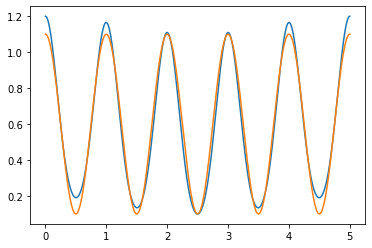

In [19]:
combined_cosine_vector = 0.1 * cos_02_vector + 0.1 * cos_2_vector + cos_1_vector
plt.plot(time_vector, combined_cosine_vector)
plt.plot(time_vector, cos_1_vector + 0.1)
plt.show()

# And now?

In [20]:
def rotated_freq(time_vector, signal, f):
    k = -2j * np.pi
    return np.exp(k*f*time_vector) * signal

In [21]:
def polar(z):
    a= z.real
    b= z.imag
    r = math.hypot(a,b)
    theta = math.atan2(b,a)
    return theta, r

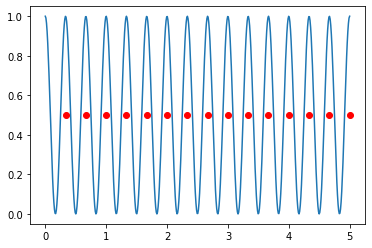

In [22]:
cos_3 = cosine(time_vector, 3)
plt.plot(time_vector, cos_3)
plot_freq_points(3, time, y_offset=0.5)
plt.show()

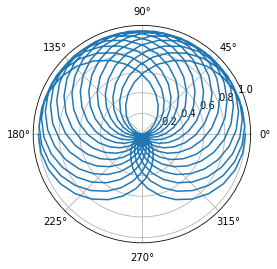

In [23]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

ax = plt.subplot(111, projection='polar')

line, = ax.plot([], [], lw=2)

def init():
    ax.plot([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    rf = rotated_freq(time_vector, cos_3, i * 0.1)
    rf_polar = np.array([polar(el) for el in rf])
    rf_theta = [el[0] for el in rf_polar] 
    rf_r = [el[1] for el in rf_polar]
    ax.clear()
    ax.plot(rf_theta, rf_r)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=30, interval=100, blit=True)

HTML(anim.to_html5_video())

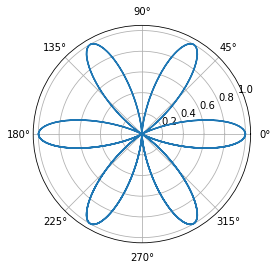

In [24]:
rf = rotated_freq(time_vector, cos_3, 0.5)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

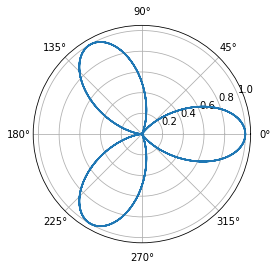

In [25]:
rf = rotated_freq(time_vector, cos_3, 1)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

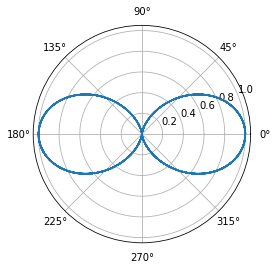

In [26]:
rf = rotated_freq(time_vector, cos_3, 1.5)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

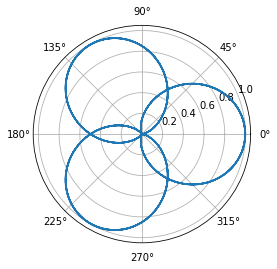

In [27]:
rf = rotated_freq(time_vector, cos_3, 2)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

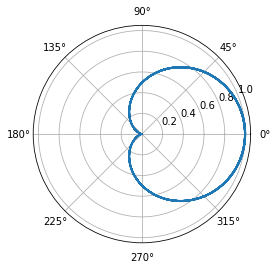

In [28]:
rf = rotated_freq(time_vector, cos_3, 3)
rf_polar = np.array([polar(el) for el in rf])
rf_theta = [el[0] for el in rf_polar] 
rf_r = [el[1] for el in rf_polar]
ax = plt.subplot(111, projection='polar')
ax.plot(rf_theta, rf_r)
plt.show()

In [29]:
mean = np.mean(rf)
print(mean.real)
print(mean.imag)

0.25150247236212453
8.704148513061228e-17


In [30]:
mass_centers_real = []
mass_centers_imag = []
for i in np.arange(0, 100, 0.1):
    rf = rotated_freq(time_vector, cos_3, i)
    mean = np.mean(rf)
    mass_centers_real.append(mean.real)
    mass_centers_imag.append(mean.imag)


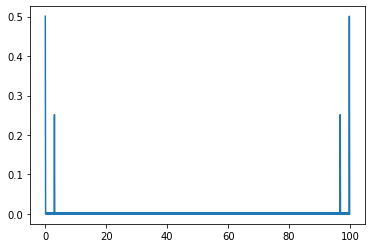

In [31]:
plt.plot(np.arange(0, 100, 0.1), mass_centers_real)

In [76]:
mass_centers_real = []
mass_centers_imag = []
for i in np.arange(0.1, 99, 0.1):
    rf = rotated_freq(time_vector, cos_3, i)
    mean = np.mean(rf)
    mass_centers_real.append(mean.real)
    mass_centers_imag.append(mean.imag)


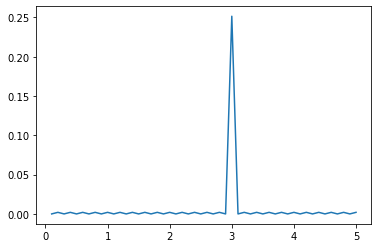

In [77]:
plt.plot(np.arange(0.1, 99, 0.1)[:50], mass_centers_real[:50])
plt.show()

In [81]:
def fourier_transform(time_vector, wave, sampling_frequency):
    mass_centers_real = []
    mass_centers_imag = []
    freqs = []
    period = 1 / sampling_frequency
    stop = sampling_frequency / 2
    for i in np.arange(period, stop, period):
        freqs.append(i)
        rf = rotated_freq(time_vector, wave, i)
        mean = np.mean(rf)
        mass_centers_real.append(mean.real)
        mass_centers_imag.append(mean.imag)
    return freqs, mass_centers_real, mass_centers_imag


In [82]:
combined_cosine_vector = cos_1_vector + cos_02_vector + cos_2_vector
f, r, i = fourier_transform(time_vector, cos_3, sampling_frequency)

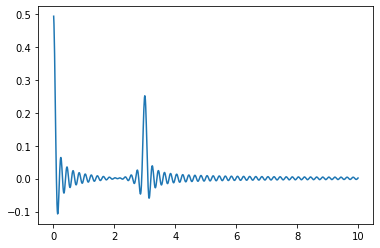

In [83]:
plt.plot(f[:1000], r[:1000])